In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap as UMAP

In [2]:
cancer = load_breast_cancer()
data = cancer.data
labels = cancer.target

df = pd.DataFrame(data, columns=cancer.feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [37]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

umap = UMAP.UMAP(n_components=2, min_dist=0.1, n_neighbors=15)
data_umap = umap.fit_transform(scaled_data)


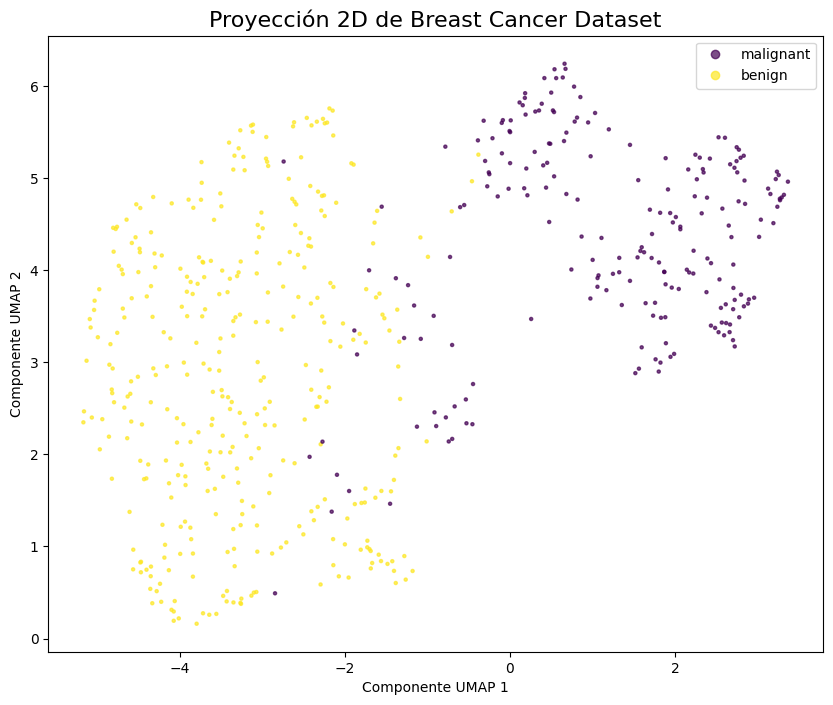

In [38]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_umap[:, 0], data_umap[:, 1], c=labels, s=5, alpha=0.7)
plt.title('Proyección 2D de Breast Cancer Dataset', fontsize=16)
plt.xlabel('Componente UMAP 1')
plt.ylabel('Componente UMAP 2')
plt.legend(handles=scatter.legend_elements()[0], labels=[cancer.target_names[i] for i in range(2)])
plt.show()

In [47]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(data_umap)

In [48]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(labels, kmeans_labels)
print(f"\nAdjusted Rand Index (ARI) Kmeans sobre datos originales: {ari:.4f}")


Adjusted Rand Index (ARI) Kmeans sobre datos originales: 0.7794


In [50]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score

labels_map = np.zeros(2)
for i in range(2):
    mask = kmeans_labels == i # Genera una lista con 0 y 1 (1 cuando la etiqueta coincide con la asignada por kmeans)
    # Convertir labels a tipo numérico antes de usar mode
    labels_map[i] = mode(labels[mask].astype(int), keepdims=True)[0][0] # Busca el número más común (usando las etiquetas originales y le reasigna ese número a kmeans)

labels_pred = np.array([labels_map[label] for label in kmeans_labels])

accuracy = accuracy_score(labels.astype(int), labels_pred) # También convertir labels a int para accuracy_score
accuracy

0.9420035149384886

/tmp/ipython-input-1503073009.py:15: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 10
  axes[1].legend(handles=scatter2.legend_elements()[0], labels=[f'C{i}' for i in range(10)])


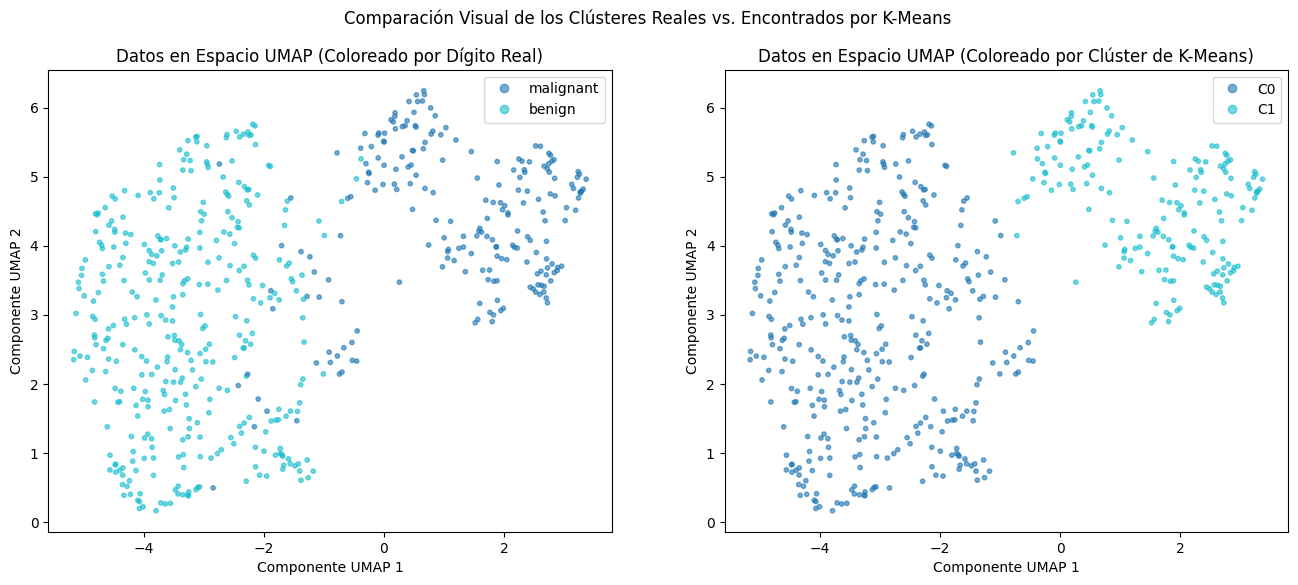

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Coloreado por etiquetas verdaderas
scatter1 = axes[0].scatter(data_umap[:, 0], data_umap[:, 1], c=labels, cmap='tab10', alpha=0.6, s=10)
axes[0].set_title('Datos en Espacio UMAP (Coloreado por Dígito Real)')
axes[0].set_xlabel('Componente UMAP 1')
axes[0].set_ylabel('Componente UMAP 2')
axes[0].legend(handles=scatter1.legend_elements()[0], labels=[cancer.target_names[i] for i in range(2)])

# Coloreado por clústeres encontrados por K-Means
scatter2 = axes[1].scatter(data_umap[:, 0], data_umap[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.6, s=10)
axes[1].set_title('Datos en Espacio UMAP (Coloreado por Clúster de K-Means)')
axes[1].set_xlabel('Componente UMAP 1')
axes[1].set_ylabel('Componente UMAP 2')
axes[1].legend(handles=scatter2.legend_elements()[0], labels=[f'C{i}' for i in range(10)])

plt.suptitle("Comparación Visual de los Clústeres Reales vs. Encontrados por K-Means")
plt.show()

Generando Matriz de Confusión...


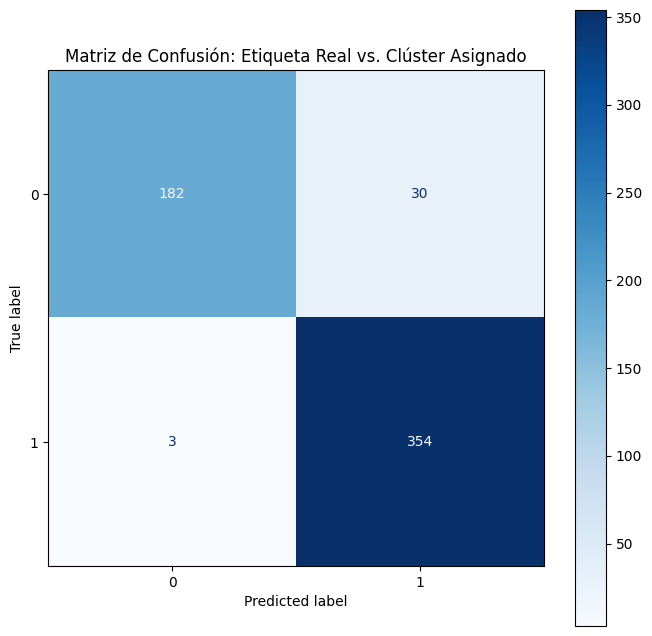

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("Generando Matriz de Confusión...")
cm = confusion_matrix(labels, labels_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(2))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title("Matriz de Confusión: Etiqueta Real vs. Clúster Asignado")
plt.show() # 0 maligno, 1 benigno